<a href="https://colab.research.google.com/github/MatheusCarne/mineracaodados/blob/main/minera%C3%A7%C3%A3os3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Carregar os dados
ratings_df = pd.read_csv('/content/ratings.csv')
movies_df = pd.read_csv('/content/movies.csv')
links_df = pd.read_csv('/content/links.csv')
tags_df = pd.read_csv('/content/tags.csv')

In [ ]:
print("Colunas de ratings:", ratings_df.columns)
print("Colunas de movies:", movies_df.columns)
print("Colunas de links:", links_df.columns)
print("Colunas de tags:", tags_df.columns)

Colunas de ratings: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Colunas de movies: Index(['movieId', 'title', 'genres'], dtype='object')
Colunas de links: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
Colunas de tags: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')


# Estrutura do Arquivo de ratings

Os usuários do MovieLens foram selecionados aleatoriamente para inclusão. Seus IDs foram anonimizados. Os IDs de usuário são consistentes entre ratings.csv e tags.csv (ou seja, o mesmo ID se refere ao mesmo usuário nos dois arquivos).

Apenas filmes com pelo menos uma classificação ou tag são incluídos no conjunto de dados. Esses IDs de filmes são consistentes com os usados ​​no site do MovieLens (por exemplo, o ID `1` corresponde à URL <https://movielens.org/movies/1>). Os IDs de filmes são consistentes entre `ratings.csv`, `tags.csv`, `movies.csv` e `links.csv` (ou seja, o mesmo ID se refere ao mesmo filme nesses quatro arquivos de dados).

Todas as classificações estão contidas no arquivo `ratings.csv`. Cada linha deste arquivo após a linha de cabeçalho representa uma avaliação de um filme por um usuário e tem o seguinte formato:

userId,movieId,rating,timestamp

As linhas dentro deste arquivo são ordenadas primeiro por userId e, em seguida, dentro de user, por movieId.

As classificações são feitas em uma escala de 5 estrelas, com incrementos de meia estrela (0,5 estrela - 5,0 estrelas).

Os timestamps representam segundos desde a meia-noite do Tempo Universal Coordenado (UTC) de 1º de janeiro de 1970.

In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
774160,5085,356,5.0,962407180
774161,5085,357,4.0,962408582
774162,5085,361,4.0,962408786
774163,5085,364,5.0,962408963


# Estrutura do Arquivo de Dados de Filmes (movies.csv)

As informações do filme estão contidas no arquivo `movies.csv`. Cada linha deste arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato:

movieId,título,gêneros

Os títulos dos filmes são inseridos manualmente ou importados de <https://www.themoviedb.org/> e incluem o ano de lançamento entre parênteses. Podem existir erros e inconsistências nesses títulos.

Os gêneros são uma lista separada por barras verticais.

In [ ]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


# Estrutura do Arquivo de Dados de Links (links.csv)

Identificadores que podem ser usados ​​para vincular a outras fontes de dados de filmes estão contidos no arquivo `links.csv`. Cada linha deste arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato:

movieId,imdbId,tmdbId

movieId é um identificador para filmes usados ​​por <https://movielens.org>. Por exemplo, o filme Toy Story tem o link <https://movielens.org/movies/1>.

imdbId é um identificador para filmes usados ​​por <http://www.imdb.com>. Por exemplo, o filme Toy Story tem o link <http://www.imdb.com/title/tt0114709/>.

tmdbId é um identificador para filmes usados ​​por <https://www.themoviedb.org>. Por exemplo, o filme Toy Story tem o link <https://www.themoviedb.org/movie/862>.

O uso dos recursos listados acima está sujeito aos termos de cada provedor.

In [ ]:
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
87580,292731,26812510,1032473.0
87581,292737,14907358,986674.0
87582,292753,12388280,948139.0
87583,292755,64027,182776.0


# Estrutura do Arquivo de Dados de Tags (tags.csv)

Todas as tags estão contidas no arquivo `tags.csv`. Cada linha deste arquivo após a linha de cabeçalho representa uma tag aplicada a um filme por um usuário e tem o seguinte formato:

userId,movieId,tag,timestamp

As linhas dentro deste arquivo são ordenadas primeiro por userId e, dentro de user, por movieId.

Tags são metadados gerados pelo usuário sobre filmes. Cada tag normalmente é uma única palavra ou frase curta. O significado, o valor e a finalidade de uma tag específica são determinados por cada usuário.

Timestamps representam segundos desde a meia-noite do Tempo Universal Coordenado (UTC) de 1º de janeiro de 1970.

In [ ]:
tags_df

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102
...,...,...,...,...
2000067,162279,90645,Rafe Spall,1320817734
2000068,162279,91079,Anton Yelchin,1322337407
2000069,162279,91079,Felicity Jones,1322337400
2000070,162279,91658,Rooney Mara,1325828398


# Agora, vamos analisar a frequência de avaliações por usuário.

Distribuição do número de avaliações por usuário:


,count
count,105688.000000
mean,159.634045
std,276.533467
min,20.000000
25%,36.000000
50%,73.000000
75%,167.000000
max,9577.000000


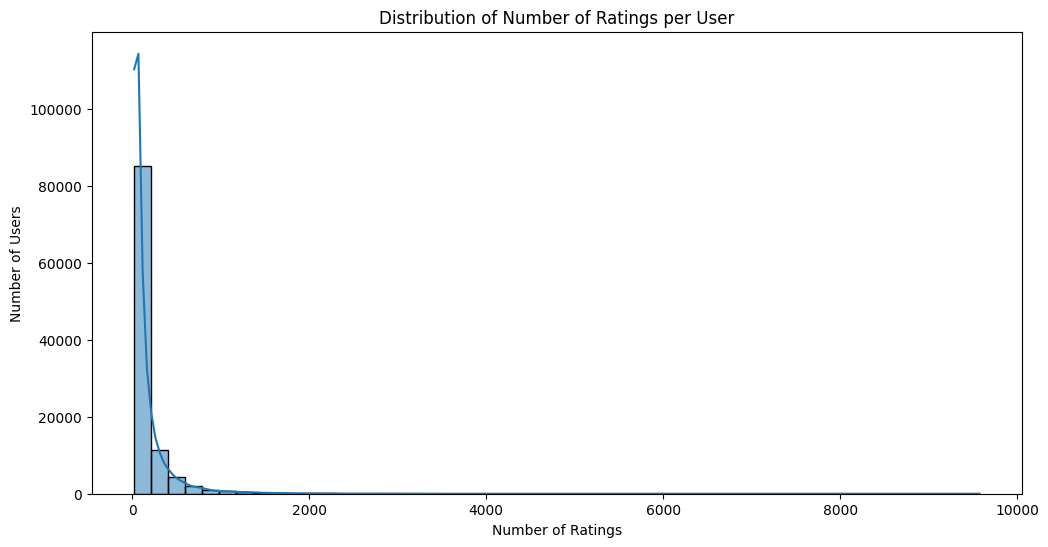

In [11]:
user_ratings_counts = ratings_df['userId'].value_counts()
print("Distribuição do número de avaliações por usuário:")
display(user_ratings_counts.describe())

plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_counts, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

# Em seguida, analisaremos a frequência de avaliações por filme.


Distribuição do número de avaliações por filme:


,count
count,71063.000000
mean,237.414731
std,1483.568527
min,1.000000
25%,1.000000
50%,4.000000
75%,21.000000
max,54151.000000


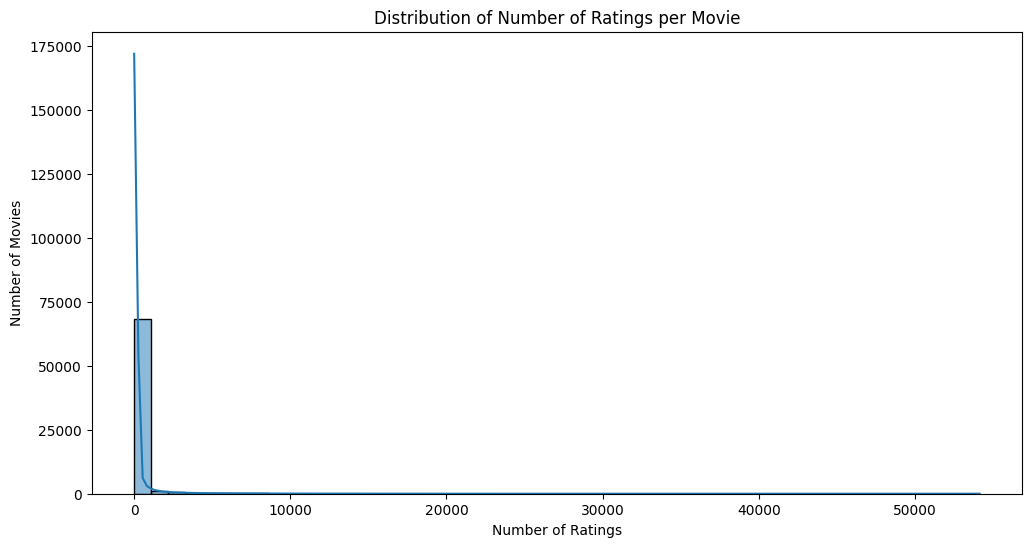

In [12]:
movie_ratings_counts = ratings_df['movieId'].value_counts()
print("\nDistribuição do número de avaliações por filme:")
display(movie_ratings_counts.describe())

plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings_counts, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

# Agora visualizando o número de classificações ao longo do tempo.

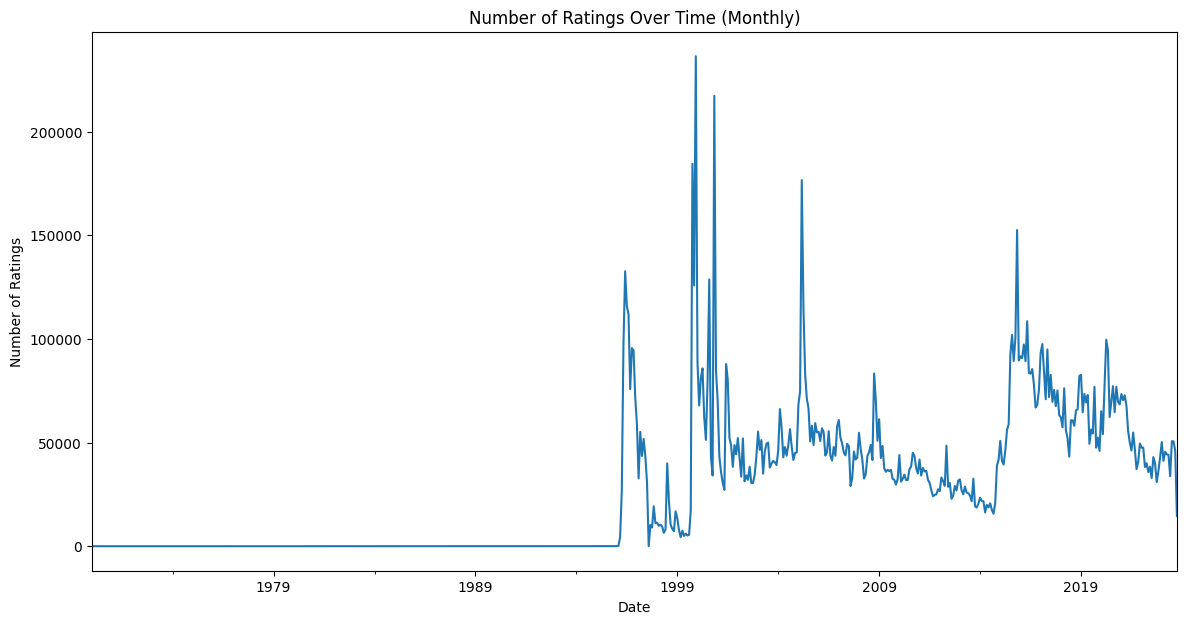

In [14]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

plt.figure(figsize=(14, 7))
ratings_df.set_index('timestamp').resample('ME')['rating'].count().plot()
plt.title('Number of Ratings Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()

## Explorar o dataframe `movies df`

Analisar a distribuição de filmes por ano de lançamento (extraindo o ano do título). Explorar a distribuição de gêneros (`genres`). Identificar filmes com títulos duplicados ou formatos de título incomuns.

Para analisar a distribuição de filmes por ano de lançamento, preciso extrair o ano da coluna 'título' e então visualizar sua distribuição.

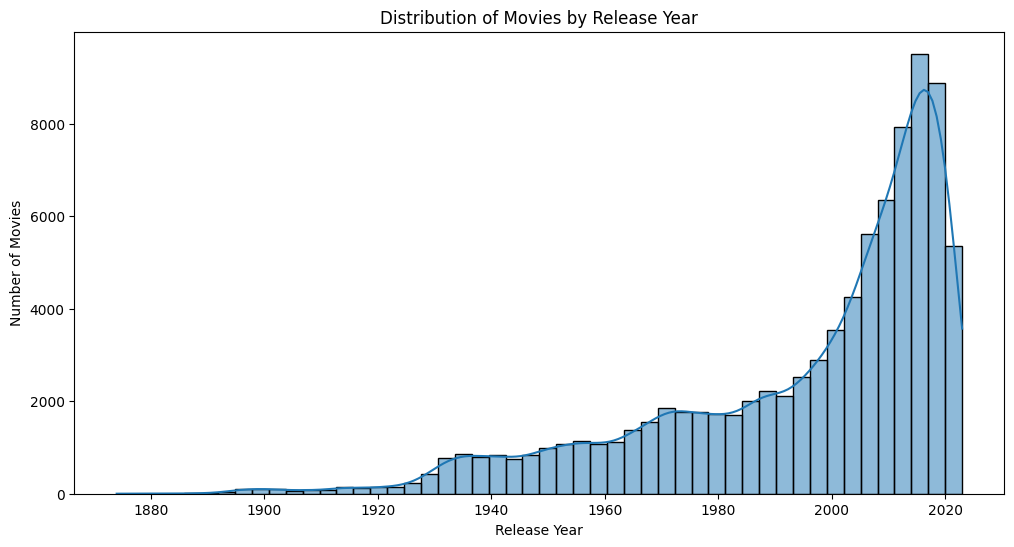

In [15]:
# Extrair o ano de lançamento do título do filme
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

plt.figure(figsize=(12, 6))
sns.histplot(movies_df['year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

Em seguida, exploraremos a distribuição de gêneros extraindo-os e contando-os, e então visualizando sua distribuição.

<ipython-input-16-1205486038>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=genres, order=genres.value_counts().index, palette='viridis')


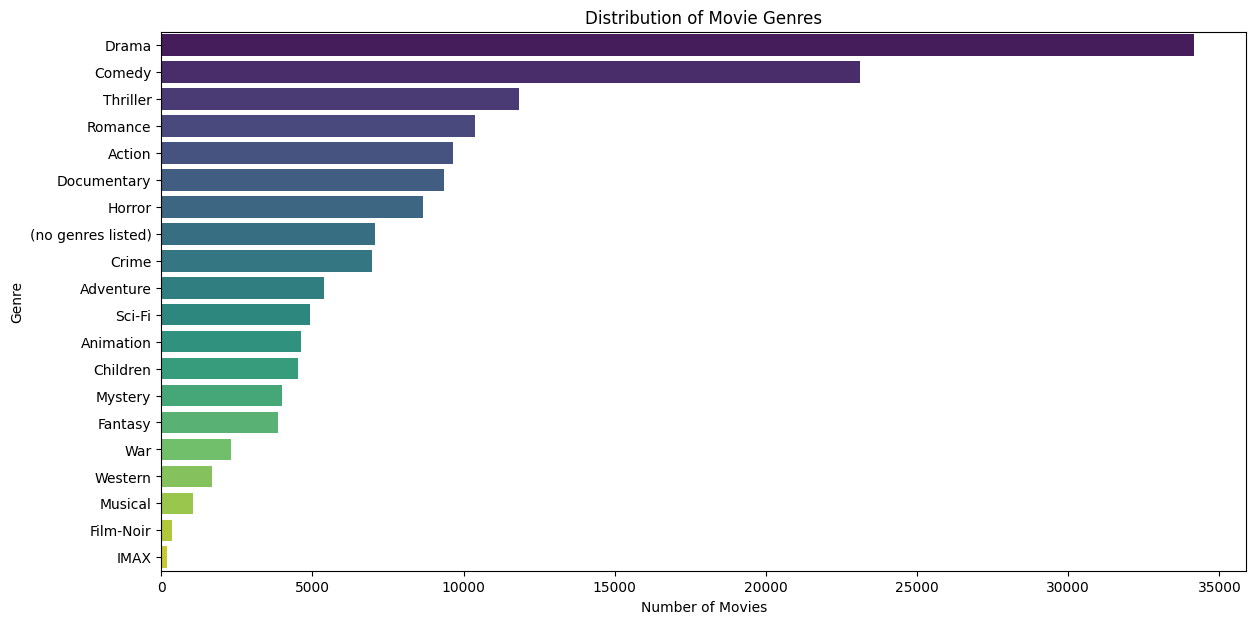

In [16]:
# Explodir a coluna 'genres' para ter uma linha por gênero por filme
genres = movies_df['genres'].str.split('|').explode()

plt.figure(figsize=(14, 7))
sns.countplot(y=genres, order=genres.value_counts().index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

Agora, identificaremos filmes com títulos duplicados ou formatos de títulos incomuns.

In [17]:
# Identificar títulos duplicados
duplicate_titles = movies_df[movies_df.duplicated('title', keep=False)].sort_values('title')
print("Filmes com títulos duplicados:")
display(duplicate_titles)

# Identificar títulos com formatos incomuns (opcional, pode exigir inspeção manual ou regex mais complexo)
# Por enquanto, vamos apenas imprimir alguns exemplos de títulos para inspeção visual
print("\nExemplos de títulos para inspeção de formato incomum:")
display(movies_df['title'].sample(20))

Filmes com títulos duplicados:


,movieId,title,genres,year
74770,245234,2020 (2020),Comedy,2020.0
71461,230389,2020 (2020),Documentary,2020.0
18413,96456,ATM (2012),Horror|Thriller,2012.0
67307,217057,ATM (2012),Comedy|Romance,2012.0
30796,136696,Absolution (2015),Action|Adventure|Crime|Thriller,2015.0
...,...,...,...,...
17396,91199,Weekend (2011),Drama|Romance,2011.0
57761,195275,White Lily (2016),Drama|Sci-Fi,2016.0
67108,216597,White Lily (2016),Drama,2016.0
81594,274159,Yellow (2006),(no genres listed),2006.0



Exemplos de títulos para inspeção de formato incomum:


,title
83995,Kino's Journey (2003)
58949,A Pest in the House (1947)
21928,Panic (2001)
64999,My Favorite Shapes by Julio Torres (2019)
37762,Above Dark Waters (2013)
62717,Enter the Anime (2019)
46847,Puck Hogs (2009)
11658,Four Minutes (Vier Minuten) (2006)
30301,Encounters of the Spooky Kind (1980)
44976,The Red Lanterns (1963)


## Explorar o dataframe `tags df`

Analisar a frequência de tags por usuário (`userId`). Analisar a frequência de tags por filme (`movieId`). Identificar as tags mais frequentes. Investigar a distribuição temporal das tags (`timestamp`). Identificar possíveis anomalias ou padrões nos dados de tags.

Primeiro, analisaremos a frequência de tags por usuário e por filme, e identificaremos as tags mais frequentes.

In [18]:
# Analisar a frequência de tags por usuário
user_tags_counts = tags_df['userId'].value_counts()
print("Distribuição do número de tags por usuário:")
display(user_tags_counts.describe())

# Analisar a frequência de tags por filme
movie_tags_counts = tags_df['movieId'].value_counts()
print("\nDistribuição do número de tags por filme:")
display(movie_tags_counts.describe())

# Identificar as tags mais frequentes
top_tags = tags_df['tag'].value_counts().head(20)
print("\nTop 20 tags mais frequentes:")
display(top_tags)

Distribuição do número de tags por usuário:


,count
count,15848.000000
mean,126.203433
std,5770.089555
min,1.000000
25%,2.000000
50%,5.000000
75%,25.000000
max,723473.000000



Distribuição do número de tags por filme:


,count
count,51323.000000
mean,38.970286
std,160.935483
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,6697.000000



Top 20 tags mais frequentes:


,count
tag,
sci-fi,10996
atmospheric,9589
action,8473
comedy,8139
funny,7467
surreal,7231
visually appealing,7090
based on a book,6617
twist ending,6521


Em seguida, investigaremos a distribuição temporal das tags convertendo o registro de data e hora em um objeto de data e hora e visualizando o número de tags ao longo do tempo.

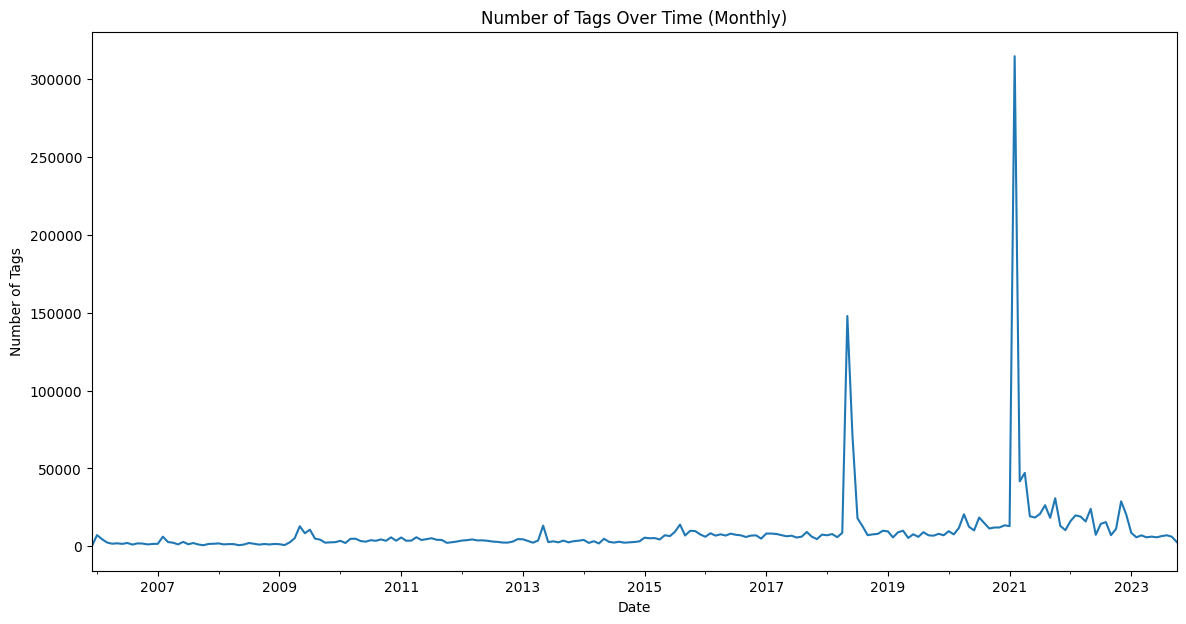

In [19]:
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')

plt.figure(figsize=(14, 7))
tags_df.set_index('timestamp').resample('ME')['tag'].count().plot()
plt.title('Number of Tags Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Tags')
plt.show()

## Explorar o dataframe `links df`

Verificar a completude e a consistência dos IDs (`imdbId`, `tmdbId`). Analisar a relação entre os IDs. Identificar possíveis anomalias ou padrões nos dados de links.

Primeiro, vamos verificar a integridade dos IDs no links_df.

In [20]:
print("Informações sobre valores ausentes no links_df:")
display(links_df.isnull().sum())

print("\nNúmero de links únicos:")
display(links_df.nunique())

Informações sobre valores ausentes no links_df:


,0
movieId,0
imdbId,0
tmdbId,124



Número de links únicos:


,0
movieId,87585
imdbId,87585
tmdbId,87425


Agora, analisaremos a relação entre imdbId e tmdbId verificando quantos filmes têm ambos os IDs.

In [21]:
# Verificar quantos filmes têm ambos imdbId e tmdbId
movies_with_both_ids = links_df.dropna(subset=['imdbId', 'tmdbId'])
print(f"\nNúmero de filmes com ambos imdbId e tmdbId: {len(movies_with_both_ids)}")

# Opcional: verificar se há movieId duplicado em links_df (já verificado implicitamente com nunique)
# print("\nVerificando por movieIds duplicados no links_df:")
# display(links_df.duplicated('movieId').sum())


Número de filmes com ambos imdbId e tmdbId: 87461


## Sumarizar as variáveis quantitativas

Vamos calcular as medidas de tendência central (média, mediana, moda) e medidas de dispersão (desvio padrão, variância, valores mínimo e máximo, quartis) para as variáveis quantitativas nos dataframes.

In [22]:
# Variáveis quantitativas nos dataframes: 'rating', 'timestamp' (em ratings_df), 'year' (em movies_df), 'timestamp' (em tags_df)
# Para simplificar, vamos focar nas variáveis numéricas que fazem mais sentido para estas métricas: 'rating' e 'year'.
# Embora 'timestamp' seja numérico, suas métricas de resumo são menos informativas do que sua distribuição temporal.

print("Sumário das variáveis quantitativas:")

# Sumário para 'rating' em ratings_df
print("\nSumário da variável 'rating' (ratings_df):")
display(ratings_df['rating'].describe())
print(f"Moda de 'rating': {ratings_df['rating'].mode()[0]}")


# Sumário para 'year' em movies_df
print("\nSumário da variável 'year' (movies_df):")
display(movies_df['year'].describe())
# A moda pode ter múltiplos valores, então exibimos todos se existirem
mode_year = movies_df['year'].mode()
print(f"Moda de 'year': {mode_year.tolist()}")

Sumário das variáveis quantitativas:

Sumário da variável 'rating' (ratings_df):


,rating
count,1.687140e+07
mean,3.539295e+00
std,1.060022e+00
min,5.000000e-01
25%,3.000000e+00
50%,3.500000e+00
75%,4.000000e+00
max,5.000000e+00


Moda de 'rating': 4.0

Sumário da variável 'year' (movies_df):


,year
count,86970.000000
mean,1995.354226
std,26.011089
min,1874.000000
25%,1981.000000
50%,2006.000000
75%,2015.000000
max,2023.000000


Moda de 'year': [2017.0]


## Explorar as variáveis qualitativas

Vamos explorar as variáveis qualitativas ('genres' em movies_df, 'tag' em tags_df) contando a frequência absoluta e relativa de cada categoria.

In [23]:
print("\nExploração das variáveis qualitativas:")

# Exploração da variável 'genres' em movies_df
print("\nExploração da variável 'genres' (movies_df):")
genres_counts = genres.value_counts() # Reutilizando a variável 'genres' criada anteriormente
genres_freq_abs = genres_counts
genres_freq_rel = genres_counts / genres_counts.sum() * 100

genres_summary_df = pd.DataFrame({
    'Frequência Absoluta': genres_freq_abs,
    'Frequência Relativa (%)': genres_freq_rel
})
display(genres_summary_df)


# Exploração da variável 'tag' em tags_df
print("\nExploração da variável 'tag' (tags_df):")
tags_counts = tags_df['tag'].value_counts()
tags_freq_abs = tags_counts
tags_freq_rel = tags_counts / tags_counts.sum() * 100

tags_summary_df = pd.DataFrame({
    'Frequência Absoluta': tags_freq_abs,
    'Frequência Relativa (%)': tags_freq_rel
})
display(tags_summary_df)


Exploração das variáveis qualitativas:

Exploração da variável 'genres' (movies_df):


,Frequência Absoluta,Frequência Relativa (%)
genres,,
Drama,34175,22.167088
Comedy,23124,14.999027
Thriller,11823,7.668807
Romance,10369,6.725692
Action,9668,6.271000
Documentary,9363,6.073166
Horror,8654,5.613284
(no genres listed),7080,4.592333
Crime,6976,4.524875



Exploração da variável 'tag' (tags_df):


,Frequência Absoluta,Frequência Relativa (%)
tag,,
sci-fi,10996,0.549785
atmospheric,9589,0.479437
action,8473,0.423638
comedy,8139,0.406939
funny,7467,0.373340
...,...,...
theft of money,1,0.000050
walking around nude,1,0.000050
woman lights a cigarette,1,0.000050
